# [COM6513] Assignment 2: Text Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward neural network for text classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**2 marks**)


- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**2 marks**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**2 marks**)
    - **Output layer** with a **softmax** activation. (**2 marks**)


- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**2 marks**)
    - Perform a **Forward pass** to compute intermediate outputs (**5 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**12 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**4 marks**)



- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500}, the dropout rate {e.g. 0.2, 0.5} and the learning rate. Please use tables or graphs to show training and validation performance for each hyperparameter combination  (**5 marks**). 



- After training a model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy. Does your model overfit, underfit or is about right? (**2 marks**).



- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**7 marks**).



- Extend you Feedforward network by adding more hidden layers (e.g. one more or two). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**8 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices (**5 marks**). 



- Provide efficient solutions by using Numpy arrays when possible. Executing the whole notebook with your code should not take more than 10 minutes on any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs and loading the pretrained vectors. You can find tips in [Intro to Python for NLP](https://sheffieldnlp.github.io/com6513/assets/labs/a0_python_intro.pdf) (**2 marks**). 



### Data 

The data you will use for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You should submit a Jupyter Notebook file (assignment2.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).


You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are **not allowed to use any third-party library** such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras, Pytorch etc.. You should mention if you've used Windows to write and test your code because we mostly use Unix based machines for marking (e.g. Ubuntu, MacOS). 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 60. It is worth 60\% of your final grade in the module.

The deadline for this assignment is **23:59 on Fri, 23 Apr 2021** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



I have used Windows to write and test my code.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc
from numpy.linalg import norm
# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)

## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
df1 = pd.read_csv('./data_topic/train.csv', encoding = 'UTF-8', header = None)
df2 = pd.read_csv('./data_topic/dev.csv', encoding = 'UTF-8', header = None)
df3 = pd.read_csv('./data_topic/test.csv', encoding = 'UTF-8', header = None)

In [3]:
train_attri = df1.iloc[:, 1].tolist()
train_label = df1.iloc[:, 0]
dev_attri = df2.iloc[:, 1].tolist()
dev_label = df2.iloc[:, 0]
test_attri = df3.iloc[:, 1].tolist()
test_label = df3.iloc[:, 0]

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [4]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [5]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                   stop_words=[], vocab=set()):
    
    tokenRE = re.compile(token_pattern)
    
    # first extract all unigrams by tokenising
    x_uni = [w for w in tokenRE.findall(str(x_raw).lower(),) if w not in stop_words]
    
    # this is to store the ngrams to be returned
    x = []

    if ngram_range[0]==1:
        x = x_uni
        
    # generate n-grams from the available unigrams x_uni
    ngrams = []
    for n in range(ngram_range[0], ngram_range[1]+1):

    # ignore unigrams
        if n==1: continue

        # pass a list of lists as an argument for zip
        arg_list = [x_uni]+[x_uni[i:] for i in range(1, n)]

        # extract tuples of n-grams using zip
        # for bigram this should look: list(zip(x_uni, x_uni[1:]))
        # align each item x[i] in x_uni with the next one x[i+1]. 
        # Note that x_uni and x_uni[1:] have different lenghts
        # but zip ignores redundant elements at the end of the second list
        # Alternatively, this could be done with for loops
        x_ngram = list(zip(*arg_list))
        ngrams.append(x_ngram)


    for n in ngrams:
        for t in n:
            x.append(t)

    if len(vocab)>0:
        x = [w for w in x if w in vocab]
        
    return x

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [6]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, 
              stop_words=[]):
    
    
    tokenRE = re.compile(token_pattern)
    
    df = Counter()
    ngram_counts = Counter()
    vocab = set()
    
    # interate through each raw text
    for x in X_raw:
        
        x_ngram = extract_ngrams(x, ngram_range=ngram_range, token_pattern=token_pattern, 
                                 stop_words=stop_words)
        
        #update doc and ngram frequencies 
        df.update(list(set(x_ngram)))
        ngram_counts.update(x_ngram)

    # obtain a vocabulary as a set. 
    # Keep elements with doc frequency > minimum doc freq (min_df)
    # Note that df contains all te
    vocab = set([w for w in df if df[w]>=min_df])
    
    # keep the top N most freqent 
    if keep_topN>0:
        vocab = set([w[0] for w in ngram_counts.most_common(keep_topN) 
                     if w[0] in vocab])
      
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [7]:
# Extract vocabulary from training data.
vocab = get_vocab(train_attri, ngram_range=(1,1), min_df=7, keep_topN=1000, stop_words=stop_words)

Then, you need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [8]:
def create_2_dict(result_from_vocab):
    id_word = dict()
    word_id = dict()
    id = 1
    for gram in result_from_vocab[0]:
        id_word.update({id: gram})
        word_id.update({gram: id})
        id += 1
    return id_word, word_id
# Create vocabulary id -> word and word -> vocabulary id dictionaries.
id2word, word2id = create_2_dict(vocab)

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [9]:
# Represent documents in train sets as lists of words in the vocabulary.   
def docs_vocab(docs):
    set_vocab=[]
    for i in range(len(docs)):
        new_row = []
        # Extract unigrams of every document.
        ngrams = extract_ngrams(docs[i], ngram_range=(1,1), stop_words=stop_words)
        for word in ngrams:
            # For every word in each document, if the word can be found in the vocab, 
            # then contain it to a new list.
            if word in vocab[0]:
                new_row.append(word)
        # Store lists of words in the vocabulary in every document.
        set_vocab.append(new_row)
    return set_vocab
# Represent documents in train, dev and test sets as lists of words in the vocabulary
train_set_vocab = docs_vocab(train_attri)
dev_set_vocab = docs_vocab(dev_attri)
test_set_vocab = docs_vocab(test_attri)


In [10]:
# Get the max length of the longest document for creating indices matrix later.   
max_len_train = np.max([len(text) for text in train_set_vocab])
max_len_dev = np.max([len(text) for text in dev_set_vocab])
max_len_test = np.max([len(text) for text in test_set_vocab])
# Find the length of the longest sentence in train, dev and test set.
print("The length of the longest sentence in train set is: ", max_len_train)
print("The length of the longest sentence in dev set is: ", max_len_dev)
print("The length of the longest sentence in test set is: ", max_len_test)

The length of the longest sentence in train set is:  56
The length of the longest sentence in dev set is:  31
The length of the longest sentence in test set is:  50


The follow function can map one-hot input layer into an rmbedding weight matrix.

In [11]:
# Represent documents in train sets as lists of words in the vocabulary.   
def docs_indices(docs_v, width = 300):
    set_indices=[]
    for i in range(len(docs_v)):
        new_row = []
        for word in docs_v[i]:
            # For every word in each sentence, add their indices in new list.
            new_row.append(word2id[word])
        # The length of each sentence is different, so add 0 to the list whose length is less than the maximum length (56).
        new_row = new_row + [0] * (width - len(new_row))
        # Store lists of words in the vocabulary in every document.
        set_indices.append(new_row)
    return set_indices

# I will convert the list of unigrams into a list of vocabulary indices when I train the model.

Put the labels `Y` for train, dev and test sets into arrays: 

In [12]:
Y_train = train_label.to_numpy()
Y_val = dev_label.to_numpy()
Y_test = test_label.to_numpy()

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [13]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.5):
    W = list()
    # Create W with embedding_dim*num_classes dimension 
    # if there are no hidden layers between the average embedding and the output layer.
    if len(hidden_dim) == 0:
        layer = [{'weights':[np.float32(np.random.uniform(-1e-1, 1e-1)) for i in range(embedding_dim)]} for i in range(num_classes)]
        W.append(layer)
        return W
    # Create W if there are hidden layers between the average embedding and the output layer.
    else:
        # W with embedding_dim*hidden_dim[0] dimension
        layer = [{'weights':[np.float32(np.random.uniform(-1e-1, 1e-1)) for i in range(embedding_dim)]} for i in range(hidden_dim[0])]
        W.append(layer)
        # W with hidden_dim[j]*hidden_dim[j+1] dimension
        for j in range(len(hidden_dim)-1):
            layer = [{'weights':[np.float32(np.random.uniform(-1e-1, 1e-1)) for i in range(hidden_dim[j])]} for i in range(hidden_dim[j+1])]
            W.append(layer)
        # W with hidden_dim[-1]*num_classes dimension
        layer = [{'weights':[np.float32(np.random.uniform(-1e-1, 1e-1)) for i in range(hidden_dim[-1])]} for i in range(num_classes)]
        W.append(layer)
        return W 

In [14]:
# Weights = network_weights(vocab_size=3,embedding_dim=5,hidden_dim=[3], num_classes=2)

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [15]:
# To avoid the probably blow up exponents, first shift the highest value in array to zero, then compute the softmax.
def softmax(z):
    expo = np.exp(z-np.max(z))
    expo_sum = np.sum(np.exp(z-np.max(z)))
    sig = expo/expo_sum    
    return sig

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:


In [16]:
def categorical_loss(y, y_preds):
    epsilon = 1e-10
    l = -np.sum(y * np.log(y_preds + epsilon))/ y.shape[0]
    return l

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [17]:
def relu(z):
    zz = z.copy()
    a = np.maximum(0, zz)    
    return a
    
def relu_derivative(z):
    dz = z.copy()
    dz[dz <= 0] = 0
    dz[dz > 0] = 1  
    return dz

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [18]:
def dropout_mask(size, dropout_rate):
    dropout_vec = np.ones(size)
    # Decide the number of 0 in vector.
    dropout_vec[ :int(size*dropout_rate)] = 0
    np.random.shuffle(dropout_vec)
    return dropout_vec

In [19]:
print(dropout_mask(10, 0.5))
print(dropout_mask(10, 0.3))

[0. 0. 1. 1. 1. 0. 0. 1. 1. 0.]
[1. 1. 1. 0. 1. 1. 1. 1. 0. 0.]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [20]:
def forward_pass(x, W, dropout_rate=0.2):
    out_vals = {}
    h_vecs = []
    a_vecs = []
    dropout_vecs = []
    inputs = x
    w_idx = 0
    # Get all hidden layers
    W_hidden = W[:-1]
    # Get output layer
    W_output = W[-1]
    # Use ReLu function to introduce non-linearity after each hidden layer
    for layer in W_hidden:
        new_inputs = []
        for neuron in layer:
            # The vector before the activation function.
            h_vecs = np.matmul(inputs, neuron['weights'])
            # The resulting vector after passing h_vecs from the activation function.
            neuron['output'] = relu(h_vecs)
            a_vecs = neuron['output']
            new_inputs.append(a_vecs)
        inputs = new_inputs
        # Generate and implement dropout mask vector for regularisation.
        drop_vec = dropout_mask(len(inputs), dropout_rate)
        inputs = np.multiply(inputs, drop_vec)
        out_vals.update({'w'+str(w_idx): inputs})
        w_idx += 1
    # Use softmax function in output layer.
    final_output = []
    for neuron in W_output:
        h_vecs = np.matmul(inputs, neuron['weights'])
        neuron['output'] = h_vecs
        a_vecs = neuron['output']
        final_output.append(a_vecs)
    out_vals.update({'w'+str(w_idx): softmax(final_output)})
    return out_vals

The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [21]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    # Transform dictionary W to array W for calculation later.
    W_a = []
    for n in range(len(W)):
        w = []
        for neuron in W[n]:
            w.append(neuron['weights'])
        # Transform every weight matrix to array and transpose it for calculation, then append to a new list.
        W_a.append(np.array(w).T)
    for i in reversed(range(len(W))):
        # When it is output layer.
        if i == (len(W)-1):
            # Computer gradient of softmax layer with Cross-Entropy, 
            # which is the difference between the predicted probability- 
            # output of the network and the target probability output.
            delta = (out_vals['w'+str(i)] - y).reshape(1, len(y))
            # Gradient Clipping
            if norm(delta) >1e+10:
                delta = delta/norm(delta)
            #print(norm(delta))
            # Update weight
            W_a[i] -= lr * np.dot(out_vals['w'+str(i-1)].reshape(len(out_vals['w'+str(i-1)]), 1), delta)
        # When it is the hiddenlayer except the first one.
        elif i != 0 and i != (len(W)-1):
            delta = np.dot(delta, W_a[i+1].T) * relu_derivative(out_vals['w'+str(i)])
            # Gradient Clipping
            if norm(delta) >1e+10:
                delta = delta/norm(delta)
            #print(norm(delta))
            W_a[i] -= lr * np.dot(out_vals['w'+str(i-1)].reshape(len(out_vals['w'+str(i-1)]), 1), delta)
        # When it is the first layer.
        else:
            # Decide whether freezing the embedding matrix.
            if freeze_emb == False:
                delta = np.dot(delta, W_a[i+1].T) * relu_derivative(out_vals['w'+str(i)])
                # Gradient Clipping
                if norm(delta) >1e+10:
                    delta = delta/norm(delta)
                #print(norm(delta))
                W_a[i] -= lr * np.dot(np.array(x).reshape(len(x), 1), delta)
            if freeze_emb == True:
                pass
    # Transform array W to dictionary W for forward pass again.
    W = []
    for j in range(len(W_a)):
        W_trans = []
        for neuron in W_a[j].T:
            neuron = neuron.astype(np.float32)
            W_trans.append({'weights':list(neuron)})
        W.append(W_trans)
    return W

In [22]:
def one_hot(y):
    K=len(np.unique(y.tolist())) 
    eyes_mat=np.eye(K)           
    y_onehot=np.ones((y.shape[0],K)) 
    for i in range(0,y.shape[0]):
        y_onehot[i]=eyes_mat[y[i]-1]  # Update one-hot coder matrix accroding to the label value.
    return y_onehot

ytrue = one_hot(Y_train)
ytrue

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [23]:
def SGD(X_tr, Y_tr, W, X_dev, Y_dev, lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, 
        print_progress=True):
    # Transform train and dev labels to one-hot form.
    Y_tr_OH = one_hot(Y_tr)
    Y_dev_OH = one_hot(Y_dev)
    # Create two loss lists.
    training_loss_history = []
    validation_loss_history = []
    training_loss_history.append(0)
    validation_loss_history.append(0)
    weight = W.copy()
    # Zip two lists for shuffle later
    whole_data = list(zip(X_tr, Y_tr_OH.tolist()))
    X = X_tr
    Y = Y_tr_OH
    for i in range(epochs):
        y_tr_pred = []
        y_dev_pred = []
        # Shuffle data
        random.shuffle(whole_data)
        X, Y = zip(*whole_data)
        Y = np.array(Y)
        for j in range(len(X)):
            # Forward pass.
            output = forward_pass(X[j], weight, dropout)
            #print(output)
            # Backward pass.
            weight = backward_pass(X[j], Y[j], weight, output)
            #print(weight)
        
        # Use updated weights to predict train labels.  
        for m in range(len(X)):
            output_tr = forward_pass(X[m], weight, dropout)
            y_tr_pred.append(output_tr['w'+str(len(weight)-1)])        
        # Compute training loss is this epoch.
        tr_loss = categorical_loss(Y, np.array(y_tr_pred))
        training_loss_history.append(tr_loss)
        
        # Use updated weights to predict dev labels.
        for k in range(len(X_dev)):
            output_dev = forward_pass(X_dev[k], weight, dropout)
            y_dev_pred.append(output_dev['w'+str(len(weight)-1)])
        # Compute dev loss is this epoch.
        dev_loss = categorical_loss(Y_dev_OH, np.array(y_dev_pred))
        validation_loss_history.append(dev_loss)
        
        # Stop training if the difference between the current and 
        # previous validation loss is smaller than a threshold
        if abs(validation_loss_history[-1]-validation_loss_history[-2]) < tolerance:
            return weight, training_loss_history[1:], validation_loss_history[1:]    
    return weight, training_loss_history[1:], validation_loss_history[1:]

Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [24]:
# Initialise the weights of the network
Weights = network_weights(embedding_dim=300, hidden_dim=[10], num_classes=3)
# Get final embedding matrix
X_train = docs_indices(train_set_vocab, 300)
X_val = docs_indices(dev_set_vocab, 300)
X_test = docs_indices(test_set_vocab, 300)

W_final, loss_tr, dev_loss = SGD(X_train, Y_train,
                                 Weights,
                                 X_dev=X_val, 
                                 Y_dev=Y_val,
                                 lr=2e-8, 
                                 dropout=0.5,
                                 freeze_emb=False,
                                 tolerance=0.0001,
                                 epochs=10)

Plot the learning process:

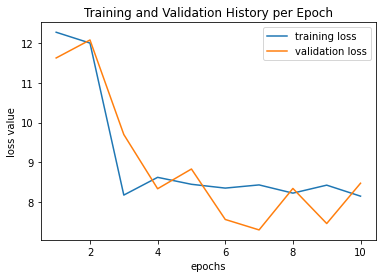

In [25]:
x = np.array(range(1, len(loss_tr)+1))
plt.plot(x, loss_tr, label='training loss')
plt.plot(x, dev_loss, label='validation loss')
plt.title("Training and Validation History per Epoch")
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.legend()

As can be seen from the above figure, the degree of overfitting of the model is low, because the two curves overlap many times, and the difference between the train loss and the validation loss set is small. Meanwhile, the model underfits because the two curves are still decreasing without convergence.

Compute accuracy, precision, recall and F1-Score:

In [26]:
# Get predicted label weights of test set.
y_test_pred = []
for i in range(len(X_test)):
    output_test = forward_pass(X_test[i], W_final, dropout_rate=0.0)
    y_test_pred.append(output_test['w'+str(len(W_final)-1)])
# Convert label weights to the real label class(1,2 or 3).
y_test_pred_int = []
for label in y_test_pred:
    y_test_pred_int.append(np.argmax(label)+1)
    
print('Accuracy:', accuracy_score(Y_test,y_test_pred_int))
print('Precision:', precision_score(Y_test,y_test_pred_int,average='macro'))
print('Recall:', recall_score(Y_test,y_test_pred_int,average='macro'))
print('F1-Score:', f1_score(Y_test,y_test_pred_int,average='macro'))


Accuracy: 0.33555555555555555
Precision: 0.2628762313801684
Recall: 0.33555555555555555
F1-Score: 0.17724460646313966


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Discuss how did you choose model hyperparameters ? 

To find the best hyperparameters, I chose different embbending size{56, 300, 500}, dropout rate{0.2, 0.5}, learning rate{1e-6, 1e-7, 1e-8, 1e-9} and dimension of hidden layer{20, 10}. For each model, I trained 10 epoches.

In [27]:
# # Code for hyperparameters tunning.
# # Choose hyperparameters.
# emb_size = 500
# learning_rate = 1e-6
# dropout_rate = 0.5
# # Initialse embedding matrix and weight matrix.
# X_train_tune = docs_indices(train_set_vocab, emb_size)
# X_val_tune = docs_indices(dev_set_vocab, emb_size)
# Weights_tune = network_weights(embedding_dim=emb_size, hidden_dim=[10], num_classes=3)
# # Train model, each model has a 20 dimension hidden layer and trains 10 epoches.
# W_final_tune, loss_tr_tune, dev_loss_tune = SGD(X_train_tune, Y_train,
#                                  Weights_tune,
#                                  X_dev=X_val_tune, 
#                                  Y_dev=Y_val,
#                                  lr=learning_rate, 
#                                  dropout=dropout_rate,
#                                  freeze_emb=False,
#                                  tolerance=0.0001,
#                                  epochs=10)

# # Get predicted label weights of training and validation set.
# y_train_pred = []
# y_val_pred = []
# for i in range(len(X_train_tune)):
#     output_train = forward_pass(X_train_tune[i], W_final_tune, dropout_rate=0.0)
#     y_train_pred.append(output_train['w'+str(len(W_final_tune)-1)])
# for i in range(len(X_val_tune)):
#     output_val = forward_pass(X_val_tune[i], W_final_tune, dropout_rate=0.0)
#     y_val_pred.append(output_val['w'+str(len(W_final_tune)-1)])

# # Convert label weights to the real label class(1,2 or 3).
# y_train_pred_int = []
# y_val_pred_int = []
# for label in y_train_pred:
#     y_train_pred_int.append(np.argmax(label)+1)
# for label in y_val_pred:
#     y_val_pred_int.append(np.argmax(label)+1)
    
# # Compute F1-score of the model on training and validation set.
# print('Accuracy on training set:', accuracy_score(Y_train,y_train_pred_int))
# print('Accuracy on validation set:', accuracy_score(Y_val,y_val_pred_int))

# del W_final_tune
# gc.collect()

Note: The form of the result is: "training accuracy/validation accuracy". The final learning rate value of the model is obtained by more attempts. The 4 learning rate values in the following table are just "boundaries".

Size of hidden layer: 20

|Embedding size  |Dropout rate  | lr = 1e-6  | lr = 1e-7  | lr = 1e-8  | lr = 1e-9  |
|:-:|:-:|:-:|:-:|:-:|:-:|
| 56 |0.2   |0.333/0.333   |0.333/0.333   |0.333/0.340   |0.333/0.333   |
| 56 |0.5   |0.333/0.333   |0.349/0.333   |0.333/0.333   |0.333/0.333   |
| 300|0.2   |0.333/0.333   |0.333/0.333   |0.333/0.346   |0.338/0.326   |
| 300|0.5   |0.338/0.333   |0.333/0.333   |0.366/0.340   |0.333/0.333   |
| 500|0.2   |0.323/0.333   |0.333/0.333   |0.340/0.333   |0.333/0.333   |
| 500|0.5   |0.333/0.333   |0.326/0.333   |0.333/0.340   |0.336/0.333   |

Size of hidden layer: 10

|Embedding size  |Dropout rate  | lr = 1e-6  | lr = 1e-7  | lr = 1e-8  | lr = 1e-9  |
|:-:|:-:|:-:|:-:|:-:|:-:|
| 56 |0.2   |0.357/0.340   |0.353/0.326   |0.333/0.333   |0.345/0.333   |
| 56 |0.5   |0.333/0.333   |0.334/0.333   |0.333/0.333   |0.332/0.333   |
| 300|0.2   |0.333/0.333   |0.333/0.333   |0.333/0.333   |0.343/0.334   |
| 300|0.5   |0.338/0.333   |0.333/0.333   |0.382/0.333   |0.333/0.333   |
| 500|0.2   |0.333/0.333   |0.343/0.326   |0.333/0.333   |0.333/0.333   |
| 500|0.5   |0.333/0.333   |0.333/0.333   |0.326/0.343   |0.336/0.333   |

As can be seen in the table above, the model have better performance with 10 hidden layer size, 300 embedding size, 0.5 droprate and 1e-8 learning rate, so I choose learning rate around 1e-8 for finding best hyperparameter.

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary. Generally, that should work without any problem. If you get errors, you can modify it.

In [28]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab[0]:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]-1] +=emb
    return w_emb

In [29]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",word2id, emb_size=300)

In [30]:
w_glove.shape

(1000, 300)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [31]:
# Generate indice matrix which width size equal the size of vocab(1000)
X_train_1000 = docs_indices(train_set_vocab, 1000)
X_val_1000 = docs_indices(dev_set_vocab, 1000)
X_test_1000 = docs_indices(test_set_vocab, 1000)
# Transform to array for np.dot
X_train_1000_array = np.array(X_train_1000)
X_val_1000_array = np.array(X_val_1000)
X_test_1000_array = np.array(X_test_1000)
# Get final embedding matrix for next two part.
X_train_glove = np.dot(X_train_1000_array, w_glove).tolist()
X_val_glove = np.dot(X_val_1000_array, w_glove).tolist()
X_test_glove = np.dot(X_test_1000_array, w_glove).tolist()

X_train_deep = X_train_glove.copy()
X_val_deep = X_val_glove.copy()
X_test_deep = X_test_glove.copy()

In [32]:
# Initialise the weights of the network
Weights_glove = network_weights(embedding_dim=300, hidden_dim=[20], num_classes=3)
W_final_glove, loss_tr_glove, dev_loss_glove = SGD(X_train_glove, Y_train,
                                                 Weights_glove,
                                                 X_dev=X_val_glove, 
                                                 Y_dev=Y_val,
                                                 lr=8e-9, 
                                                 dropout=0.5,
                                                 freeze_emb=True,
                                                 tolerance=0.0001,
                                                 epochs=10)

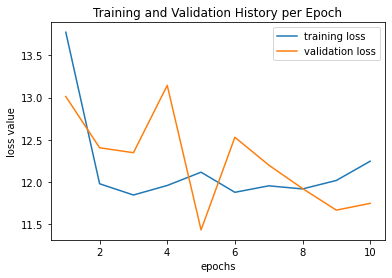

In [33]:
x = np.array(range(1, len(loss_tr_glove)+1))
plt.plot(x, loss_tr_glove, label='training loss')
plt.plot(x, dev_loss_glove, label='validation loss')
plt.title("Training and Validation History per Epoch")
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.legend()

As can be seen from the above figure, the degree of overfitting of the model is low, because the two curves overlap many times, and the difference between the train loss and the validation loss set is small. Meanwhile, the model underfits because the two curves are still decreasing without convergence.

In [34]:
# Get predicted label weights of test set.
y_test_glove_pred = []
for i in range(len(X_test_glove)):
    output_glove_test = forward_pass(X_test_glove[i], W_final_glove, dropout_rate=0.0)
    y_test_glove_pred.append(output_glove_test['w'+str(len(W_final_glove)-1)])
# Convert label weights to the real label class(1,2 or 3).
y_test_glove_pred_int = []
for label in y_test_glove_pred:
    y_test_glove_pred_int.append(np.argmax(label)+1)
    
print('Accuracy:', accuracy_score(Y_test,y_test_glove_pred_int))
print('Precision:', precision_score(Y_test,y_test_glove_pred_int,average='macro'))
print('Recall:', recall_score(Y_test,y_test_glove_pred_int,average='macro'))
print('F1-Score:', f1_score(Y_test,y_test_glove_pred_int,average='macro'))

Accuracy: 0.34
Precision: 0.5006270378730875
Recall: 0.34
F1-Score: 0.18624924605291582


In my case, compared to the first model, the performance of the model with pre-trained embeddings has been improved a little.

### Discuss how did you choose model hyperparameters ? 

To find the best hyperparameters, I choose different dropout rate{0.2, 0.5}, learning rate{1e-6, 1e-7, 1e-8, 1e-9}(embedding size is fixed as 300) and dimension of hidden layer{50, 20}. For each model, I trained 10 epoches.

In [35]:
# # Code for hyperparameters tunning.
# # Choose hyperparameters.
# emb_size = 300
# learning_rate = 1e-6
# dropout_rate = 0.5
# # Initialse weight matrix (embedding matrix is already initialised).
# Weights_glove_tune = network_weights(embedding_dim=emb_size, hidden_dim=[20], num_classes=3)
# # Train model, each model has a 20 dimension hidden layer and trains 10 epoches.
# W_glove_tune, loss_tr_tune, dev_loss_tune = SGD(X_train_glove, Y_train,
#                                              Weights_glove_tune,
#                                              X_dev=X_val_glove, 
#                                              Y_dev=Y_val,
#                                              lr=learning_rate, 
#                                              dropout=dropout_rate,
#                                              freeze_emb=True,
#                                              tolerance=0.0001,
#                                              epochs=10)

# # Get predicted label weights of training and validation set.
# y_train_glove_pred = []
# y_val_glove_pred = []
# for i in range(len(X_train_glove)):
#     output_glove_train = forward_pass(X_train_glove[i], W_glove_tune, dropout_rate=0.0)
#     y_train_glove_pred.append(output_glove_train['w'+str(len(W_glove_tune)-1)])
# for i in range(len(X_val_glove)):
#     output_glove_val = forward_pass(X_val_glove[i], W_glove_tune, dropout_rate=0.0)
#     y_val_glove_pred.append(output_glove_val['w'+str(len(W_glove_tune)-1)])
    
# # Convert label weights to the real label class(1,2 or 3).
# y_train_glove_pred_int = []
# y_val_glove_pred_int = []
# for label in y_train_glove_pred:
#     y_train_glove_pred_int.append(np.argmax(label)+1)
# for label in y_val_glove_pred:
#     y_val_glove_pred_int.append(np.argmax(label)+1)
    
# # Compute F1-score of the model on training and validation set.
# print('Accuracy on training set:', accuracy_score(Y_train,y_train_glove_pred_int))
# print('Accuracy on validation set:', accuracy_score(Y_val,y_val_glove_pred_int))

# del W_glove_tune
# gc.collect()

Note: The form of the result is: "training accuracy/validation accuracy". The final learning rate value of the model is obtained by more attempts. The 4 learning rate values in the following table are just "boundaries".

Size of hidden layer: 50

|Dropout rate  | lr = 1e-6  | lr = 1e-7  | lr = 1e-8  | lr = 1e-9  |
|:-:|:-:|:-:|:-:|:-:|
|0.2   |0.333/0.333   |0.334/0.333   |0.333/0.333   |0.334/0.333   |
|0.5   |0.326/0.333   |0.334/0.333   |0.334/0.333   |0.333/0.333   |

Size of hidden layer: 20

|Dropout rate  | lr = 1e-6  | lr = 1e-7  | lr = 1e-8  | lr = 1e-9  |
|:-:|:-:|:-:|:-:|:-:|
|0.2   |0.333/0.333   |0.333/0.333   |0.343/0.333   |0.333/0.333   |
|0.5   |0.333/0.333   |0.333/0.340   |0.354/0.333   |0.333/0.333   |

As can be seen in the table above, the model have better performance with 20 hidden layer size, 0.5 droprate and 1e-8 learning rate, so I choose learning rate around 1e-8 for finding best hyperparameter.

# Extend to support deeper architectures 

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. Do deeper architectures increase performance?

As the teacher mentioned in the group chat, I use pre-trained embeddings(GloVe) to train this model (embedding size is fixed as 300). I use two hidden layers in network. The 'backward_pass' function already support multi-layers network so I do not need to create a new function. 

In [36]:
# Initialise the weights of the network.
Weights_deep = network_weights(embedding_dim=300, hidden_dim=[50, 10], num_classes=3)
W_final_deep, loss_tr_deep, dev_loss_deep = SGD(X_train_deep, Y_train,
                                                 Weights_deep,
                                                 X_dev=X_val_deep, 
                                                 Y_dev=Y_val,
                                                 lr=8e-9, 
                                                 dropout=0.5,
                                                 freeze_emb=True,
                                                 tolerance=0.0001,
                                                 epochs=10)

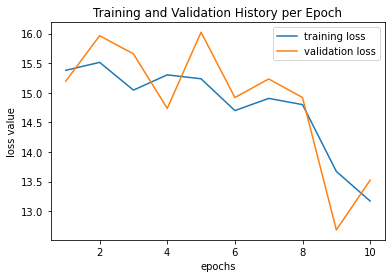

In [37]:
x = np.array(range(1, len(loss_tr_deep)+1))
plt.plot(x, loss_tr_deep, label='training loss')
plt.plot(x, dev_loss_deep, label='validation loss')
plt.title("Training and Validation History per Epoch")
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.legend()

As can be seen from the above figure, the degree of overfitting of the model is low, because the two curves overlap many times, and the difference between the train loss and the validation loss set is small. Meanwhile, the model underfits because the two curves are still decreasing without convergence.

In [38]:
# Get predicted label weights of test set.
y_test_deep_pred = []
for i in range(len(X_test_deep)):
    output_deep_test = forward_pass(X_test_deep[i], W_final_deep, dropout_rate=0.0)
    y_test_deep_pred.append(output_deep_test['w'+str(len(W_final_deep)-1)])
# Convert label weights to the real label class(1,2 or 3).
y_test_deep_pred_int = []
for label in y_test_deep_pred:
    y_test_deep_pred_int.append(np.argmax(label)+1)
    
print('Accuracy:', accuracy_score(Y_test,y_test_deep_pred_int))
print('Precision:', precision_score(Y_test,y_test_deep_pred_int,average='macro'))
print('Recall:', recall_score(Y_test,y_test_deep_pred_int,average='macro'))
print('F1-Score:', f1_score(Y_test,y_test_deep_pred_int,average='macro'))

Accuracy: 0.33444444444444443
Precision: 0.2780252412769117
Recall: 0.3344444444444445
F1-Score: 0.1691524136990643


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Compared to the above model (pre-trained embeddings with one hidden layer), the performance of the model with deeper architecture has dropped a little. So I can say that in my case, the deeper network did not have positive impact on performance.

### Discuss how did you choose model hyperparameters ? 

To find the best hyperparameters, I choose different dropout rate{0.2, 0.5},learning rate{1e-6, 1e-7, 1e-8} and hidden layer dimension {[100, 20], [100, 10], [50, 20], [50, 10]}.  For each model, I trained 10 epoches.

In [39]:
# # Code for hyperparameters tunning.
# # Choose hyperparameters.
# emb_size = 300
# learning_rate = 1e-8
# dropout_rate = 0.5
# # Initialse weight matrix (embedding matrix is already initialised).
# Weights_deep_tune = network_weights(embedding_dim=emb_size, hidden_dim=[50, 10], num_classes=3)
# # Train model, each model has a 20 dimension hidden layer and trains 10 epoches.
# W_deep_tune, loss_tr_deep_tune, dev_loss_deep_tune = SGD(X_train_deep, Y_train,
#                                                          Weights_deep_tune,
#                                                          X_dev=X_val_deep, 
#                                                          Y_dev=Y_val,
#                                                          lr=learning_rate, 
#                                                          dropout=dropout_rate,
#                                                          freeze_emb=True,
#                                                          tolerance=0.0001,
#                                                          epochs=10)

# # Get predicted label weights of training and validation set.
# y_train_deep_pred = []
# y_val_deep_pred = []
# for i in range(len(X_train_deep)):
#     output_deep_train = forward_pass(X_train_deep[i], W_deep_tune, dropout_rate=0.0)
#     y_train_deep_pred.append(output_deep_train['w'+str(len(W_deep_tune)-1)])
# for i in range(len(X_val_deep)):
#     output_deep_val = forward_pass(X_val_deep[i], W_deep_tune, dropout_rate=0.0)
#     y_val_deep_pred.append(output_deep_val['w'+str(len(W_deep_tune)-1)])
    
# # Convert label weights to the real label class(1,2 or 3).
# y_train_deep_pred_int = []
# y_val_deep_pred_int = []
# for label in y_train_deep_pred:
#     y_train_deep_pred_int.append(np.argmax(label)+1)
# for label in y_val_deep_pred:
#     y_val_deep_pred_int.append(np.argmax(label)+1)
    
# # Compute F1-score of the model on training and validation set.
# print('Accuracy on training set:', accuracy_score(Y_train,y_train_deep_pred_int))
# print('Accuracy on validation set:', accuracy_score(Y_val,y_val_deep_pred_int))

# del W_deep_tune
# gc.collect()

Note: The form of the result is: "training accuracy/validation accuracy". The final learning rate value of the model is obtained by more attempts. The 3 learning rate values in the following table are just "boundaries".

Size of hidden layer: [100, 20]

|Dropout rate  | lr = 1e-6  | lr = 1e-7  | lr = 1e-8  |
|:-:|:-:|:-:|:-:|
|0.2   |0.333/0.333   |0.333/0.333   |0.334/0.333   |
|0.5   |0.333/0.333   |0.334/0.333   |0.333/0.333   |

Size of hidden layer: [100, 10]

|Dropout rate  | lr = 1e-6  | lr = 1e-7  | lr = 1e-8  |
|:-:|:-:|:-:|:-:|
|0.2   |0.334/0.333   |0.333/0.333   |0.334/0.333   |
|0.5   |0.326/0.333   |0.333/0.334   |0.333/0.333   |

Size of hidden layer: [50, 20]

|Dropout rate  | lr = 1e-6  | lr = 1e-7  | lr = 1e-8  |
|:-:|:-:|:-:|:-:|
|0.2   |0.333/0.334   |0.326/0.333   |0.333/0.333   |
|0.5   |0.333/0.333   |0.333/0.340   |0.333/0.333   |

Size of hidden layer: [50, 10]

|Dropout rate  | lr = 1e-6  | lr = 1e-7  | lr = 1e-8  |
|:-:|:-:|:-:|:-:|
|0.2   |0.326/0.333   |0.340/0.333   |0.343/0.333   |
|0.5   |0.333/0.333   |0.333/0.333   |0.363/0.340   |

As can be seen in the table above, the model have better performance with [50, 10] hidden layers size, 0.5 droprate and 1e-8 learning rate, so I choose learning rate around 1e-8 for finding best hyperparameter.

## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  |0.262   |0.335   |0.177   |0.335   |
| Average Embedding (Pre-trained)  |0.500   |0.340   |0.186   |0.340   |
| Average Embedding (Pre-trained) + X hidden layers    |0.278   |0.334   |0.169   |0.334   |


Please discuss why your best performing model is better than the rest.

In my case, the Average Embedding (Pre-trained) model has the best performance. And I think the reason is that:

1. Compared to average embedding, Pre-train embedding matrix is carried out on a huge text corpus and can learn general language representations, so it can provide better model initialization, which usually leads to better generalization performance. At the same time, it is regarded as a kind of regularization to avoid overfitting to small data.

2. With regard to the model with deeper architexture, it is generally believed that increasing the number of hidden layers can reduce network errors and improve accuracy, but this will also complicate the network, thereby increasing the training time of the network and the tendency of "overfitting". In my case, the model with one hidden layer have better performance.